In [1]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
from joblib import dump, load
import matplotlib
import matplotlib.pyplot as plt
import sys
from datetime import datetime


from imutils import face_utils
import argparse
import imutils
import dlib

%matplotlib inline

In [2]:
# inicijalizaclija dlib detektora (HOG)
detector = dlib.get_frontal_face_detector()
# ucitavanje pretreniranog modela za prepoznavanje karakteristicnih tacaka
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

rectangles[[(479, 295) (1034, 850)]]
34.83955407689836
Nema masku


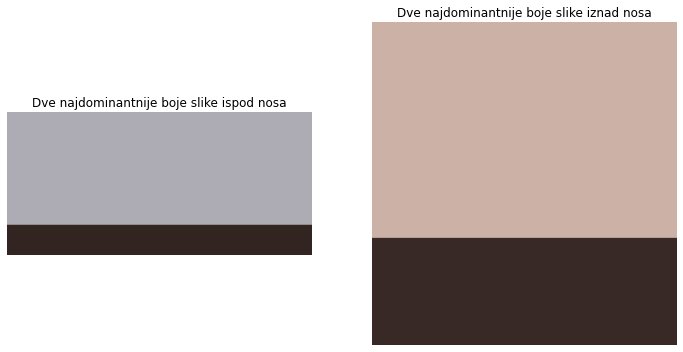

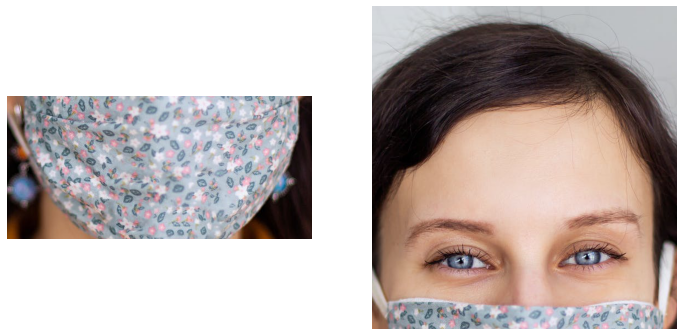

In [5]:
img = cv2.imread('dataset/with_mask/1b.jpg')
copy_img=img
gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB)
rects = detector(gray, 1)
print(rects)

for (b, rect) in enumerate(rects):

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)


    (x, y, w, h) = face_utils.rect_to_bb(rect)
    (i,j)=face_utils.FACIAL_LANDMARKS_IDXS.get('nose')
    y1=shape[29][1]

    above_nose = gray[0:y1, x:x + w]
    under_nose = gray[y1:y + h, x:x + w]


pixels_above_nose = np.float32(above_nose.reshape(-1, 3))
pixels_under_nose = np.float32(under_nose.reshape(-1, 3))

n_colors = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels_above_nose, palette_above_nose = cv2.kmeans(pixels_above_nose, n_colors, None, criteria, 10, flags)
_, counts_above_nose = np.unique(labels_above_nose, return_counts=True)

_, labels_under_nose, palette_under_nose = cv2.kmeans(pixels_under_nose, n_colors, None, criteria, 10, flags)
_, counts_under_nose = np.unique(labels_under_nose, return_counts=True)

dominant_above_nose = palette_above_nose[np.argmax(counts_above_nose)]
dominant_under_nose = palette_under_nose[np.argmax(counts_under_nose)]

# print(dominant_above_nose)
# print(dominant_under_nose)

d=np.sqrt((dominant_above_nose[0]-dominant_under_nose[0])**2+(dominant_above_nose[1]-dominant_under_nose[1])**2+(dominant_above_nose[2]-dominant_under_nose[2])**2)

print(d)

if d>42:
    print('Ima masku')
else:
    print('Nema masku')

indices = np.argsort(counts_above_nose)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts_above_nose[indices]/counts_above_nose.sum()]))
rows = np.int_(above_nose.shape[0]*freqs)

dom_patch = np.zeros(shape=above_nose.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette_above_nose[indices[i]])
    
    
indices1 = np.argsort(counts_under_nose)[::-1]   
freqs1 = np.cumsum(np.hstack([[0], counts_under_nose[indices1]/counts_under_nose.sum()]))
rows1 = np.int_(under_nose.shape[0]*freqs1)

dom_patch1 = np.zeros(shape=under_nose.shape, dtype=np.uint8)
for i in range(len(rows1) - 1):
    dom_patch1[rows1[i]:rows1[i + 1], :, :] += np.uint8(palette_under_nose[indices1[i]])
    

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(dom_patch1)
ax0.axis('off')
ax0.set_title('Dve najdominantnije boje slike ispod nosa')

ax1.imshow(dom_patch)
ax1.axis('off')
ax1.set_title('Dve najdominantnije boje slike iznad nosa')

plt.show(fig)



fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(under_nose)
ax0.axis('off')
ax1.imshow(above_nose)
ax1.axis('off')
plt.show(fig)



In [4]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rects = detector(gray, 1)

    for (b, rect) in enumerate(rects):

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)


        (x, y, w, h) = face_utils.rect_to_bb(rect)
        (i,j)=face_utils.FACIAL_LANDMARKS_IDXS.get('nose')
        y1=shape[29][1]

        above_nose = gray[0:y1, x:x + w]
        under_nose = gray[y1:y + h, x:x + w]

     
    
    pixels_above_nose = np.float32(above_nose.reshape(-1, 3))
    pixels_under_nose = np.float32(under_nose.reshape(-1, 3))

    n_colors = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels_above_nose, palette_above_nose = cv2.kmeans(pixels_above_nose, n_colors, None, criteria, 10, flags)
    _, counts_above_nose = np.unique(labels_above_nose, return_counts=True)

    _, labels_under_nose, palette_under_nose = cv2.kmeans(pixels_under_nose, n_colors, None, criteria, 10, flags)
    _, counts_under_nose = np.unique(labels_under_nose, return_counts=True)

    dominant_above_nose = palette_above_nose[np.argmax(counts_above_nose)]
    dominant_under_nose = palette_under_nose[np.argmax(counts_under_nose)]

    # print(dominant_above_nose)
    # print(dominant_under_nose)

    d=np.sqrt((dominant_above_nose[0]-dominant_under_nose[0])**2+(dominant_above_nose[1]-dominant_under_nose[1])**2+(dominant_above_nose[2]-dominant_under_nose[2])**2)
    
    if d<60:
        cv2.rectangle(frame, (x, y), (x + w , y + h ), (0, 0, 255), 2)
        cv2.putText(frame, "without mask", (x, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        cv2.rectangle(frame, (x, y), (x + w, y + h ), (0, 255, 0), 2)
        cv2.putText(frame, "with mask", (x , y ),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [6]:
file=open('dataset/annotations.csv')
data = file.read()
lines = data.split('\n')
facial_expression=[]
br_tacnih=0
ukupno=0
before = datetime.now()

for index, line in enumerate(lines):
    cols = line.split(',')
    if cols and cols[0] == '':
        continue
    cols[0] = cols[0].replace('\r', '')
    cols[1] = cols[1].replace('\r', '')

    img = cv2.imread('dataset/test/' + cols[0])
    copy_img=img
    gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB)
    rects = detector(gray, 1)

    features = [];


    for (b, rect) in enumerate(rects):

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)


        (x, y, w, h) = face_utils.rect_to_bb(rect)
        (i,j)=face_utils.FACIAL_LANDMARKS_IDXS.get('nose')
        y1=shape[29][1]

        above_nose = gray[0:y1, x:x + w]
        under_nose = gray[y1:y + h, x:x + w]


        pixels_above_nose = np.float32(above_nose.reshape(-1, 3))
        pixels_under_nose = np.float32(under_nose.reshape(-1, 3))

        n_colors = 2
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS

        _, labels_above_nose, palette_above_nose = cv2.kmeans(pixels_above_nose, n_colors, None, criteria, 10, flags)
        _, counts_above_nose = np.unique(labels_above_nose, return_counts=True)

        _, labels_under_nose, palette_under_nose = cv2.kmeans(pixels_under_nose, n_colors, None, criteria, 10, flags)
        _, counts_under_nose = np.unique(labels_under_nose, return_counts=True)

        dominant_above_nose = palette_above_nose[np.argmax(counts_above_nose)]
        dominant_under_nose = palette_under_nose[np.argmax(counts_under_nose)]

        # print(dominant_above_nose)
        # print(dominant_under_nose)

        d=np.sqrt((dominant_above_nose[0]-dominant_under_nose[0])**2+(dominant_above_nose[1]-dominant_under_nose[1])**2+(dominant_above_nose[2]-dominant_under_nose[2])**2)

        
    predikcija=0
    if d>42:
        predikcija=1
        
#     print(cols[1])
#     print(predikcija)
#     print(cols[0])
#     print('---------------')
    
    ukupno+=1
    if int(predikcija) == int(cols[1]):
        br_tacnih+=1
    
after = datetime.now()
  
print('Tacnost: '+ str(br_tacnih/ukupno*100))
print('Ukupno vreme: '+ str(after-before))

Tacnost: 68.75
Ukupno vreme: 0:00:04.551728
